In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

file_path = './amazon_user_reviews_3cat.parquet'

df = pd.read_parquet(file_path)

In [13]:
from collections import Counter
print(Counter(df["rating"]))
print(Counter(df["sentiment"]))

Counter({3.0: 6086, 5.0: 4988, 1.0: 3717, 2.0: 2418, 4.0: 1191})
Counter({0: 6179, 2: 6135, 1: 6086})


## "text_features" copy from Basic&Textual_EDA

In [14]:
# Basic length features
df['char_count'] = df['original_text'].str.len()
df['word_count'] = df['original_text'].str.split().str.len()
df['avg_word_length'] = df['char_count'] / df['word_count']

# Punctuation
df['exclamation_count'] = df['original_text'].str.count('!')
df['question_count'] = df['original_text'].str.count('\?')
df['period_count'] = df['original_text'].str.count('\.')
df['comma_count'] = df['original_text'].str.count(',')
df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')
df['total_punctuation'] = (df['exclamation_count'] + df['question_count'] +
                            df['period_count'] + df['comma_count'])

# Capitalization features
df['all_caps_words'] = df['original_text'].str.findall(r'\b[A-Z]{2,}\b').str.len()
df['uppercase_count'] = df['original_text'].str.findall(r'[A-Z]').str.len()
df['uppercase_ratio'] = df['uppercase_count'] / df['char_count']

# Binary indicators
df['has_exclamation'] = (df['exclamation_count'] > 0).astype(int)
df['has_question'] = (df['question_count'] > 0).astype(int)
df['has_all_caps'] = (df['all_caps_words'] > 0).astype(int)

text_features = ['exclamation_count', 'question_count', 'word_count',
                 'char_count', 'all_caps_words', 'uppercase_ratio',
                 'total_punctuation', 'avg_word_length']

<>:8: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_16721/1649078473.py:8: SyntaxWarning: invalid escape sequence '\?'
  df['question_count'] = df['original_text'].str.count('\?')
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_16721/1649078473.py:9: SyntaxWarning: invalid escape sequence '\.'
  df['period_count'] = df['original_text'].str.count('\.')
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_16721/1649078473.py:11: SyntaxWarning: invalid escape sequence '\.'
  df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')


## "Other_features": "helpful_vote","int_verified_purchase","hour", "month", "season"

In [15]:
# 1. DATA-PREPROCESSING

# Convert verified_purchase to integer (0: False/1: True)
df["int_verified_purchase"]= df['verified_purchase'].astype(int)

# Parse `datetime` and extract hour, month, season
# Nominal Season: 1:Spring (March–May), 2:Summer (June–August), 3:Fall (September–November), and 4:Winter (December–February). 

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
# hour: integer hour from datetime
df['hour'] = df['datetime'].dt.hour
# month: integer month (1-12)
df['month'] = df['datetime'].dt.month
# season mapping based on month
def month_to_season(m):
    if m in [3,4,5]:
        return 1
    elif m in [6,7,8]:
        return 2
    elif m in [9,10,11]:
        return 3
    elif m in [12,1,2]:
        return 4
    else:
        return None
df['season'] = df['month'].apply(month_to_season)

In [16]:
other_features =["helpful_vote","int_verified_purchase","hour", "month", "season"]
features = text_features + other_features

In [17]:
# 2. mean, median, std analysis
analysis_by_sentiment = df.groupby('sentiment')[other_features].agg(['mean', 'median', 'std'])
print("\n", analysis_by_sentiment.round(2))


           helpful_vote               int_verified_purchase               \
                  mean median    std                  mean median   std   
sentiment                                                                 
0                 1.48    0.0   9.31                   0.7    1.0  0.46   
1                 2.29    0.0  18.19                   0.7    1.0  0.46   
2                 2.64    0.0  16.00                   0.8    1.0  0.40   

            hour              month              season               
            mean median   std  mean median   std   mean median   std  
sentiment                                                             
0          12.97   15.0  7.61  6.43    6.0  3.57   2.57    3.0  1.13  
1          13.07   15.0  7.63  6.47    7.0  3.51   2.54    3.0  1.12  
2          12.93   15.0  7.63  6.44    6.0  3.53   2.55    3.0  1.13  


In [18]:
# 3. CORRELATION WITH sentiment
print("Other features: CORRELATION WITH sentiment")

# Calculate correlation of each feature with sentiment
correlations = df[other_features + ['sentiment']].corr()['sentiment'].sort_values(ascending=False)
print("\n", correlations)

Other features: CORRELATION WITH sentiment

 sentiment                1.000000
int_verified_purchase    0.088731
helpful_vote             0.031630
month                    0.001984
hour                    -0.002227
season                  -0.008761
Name: sentiment, dtype: float64


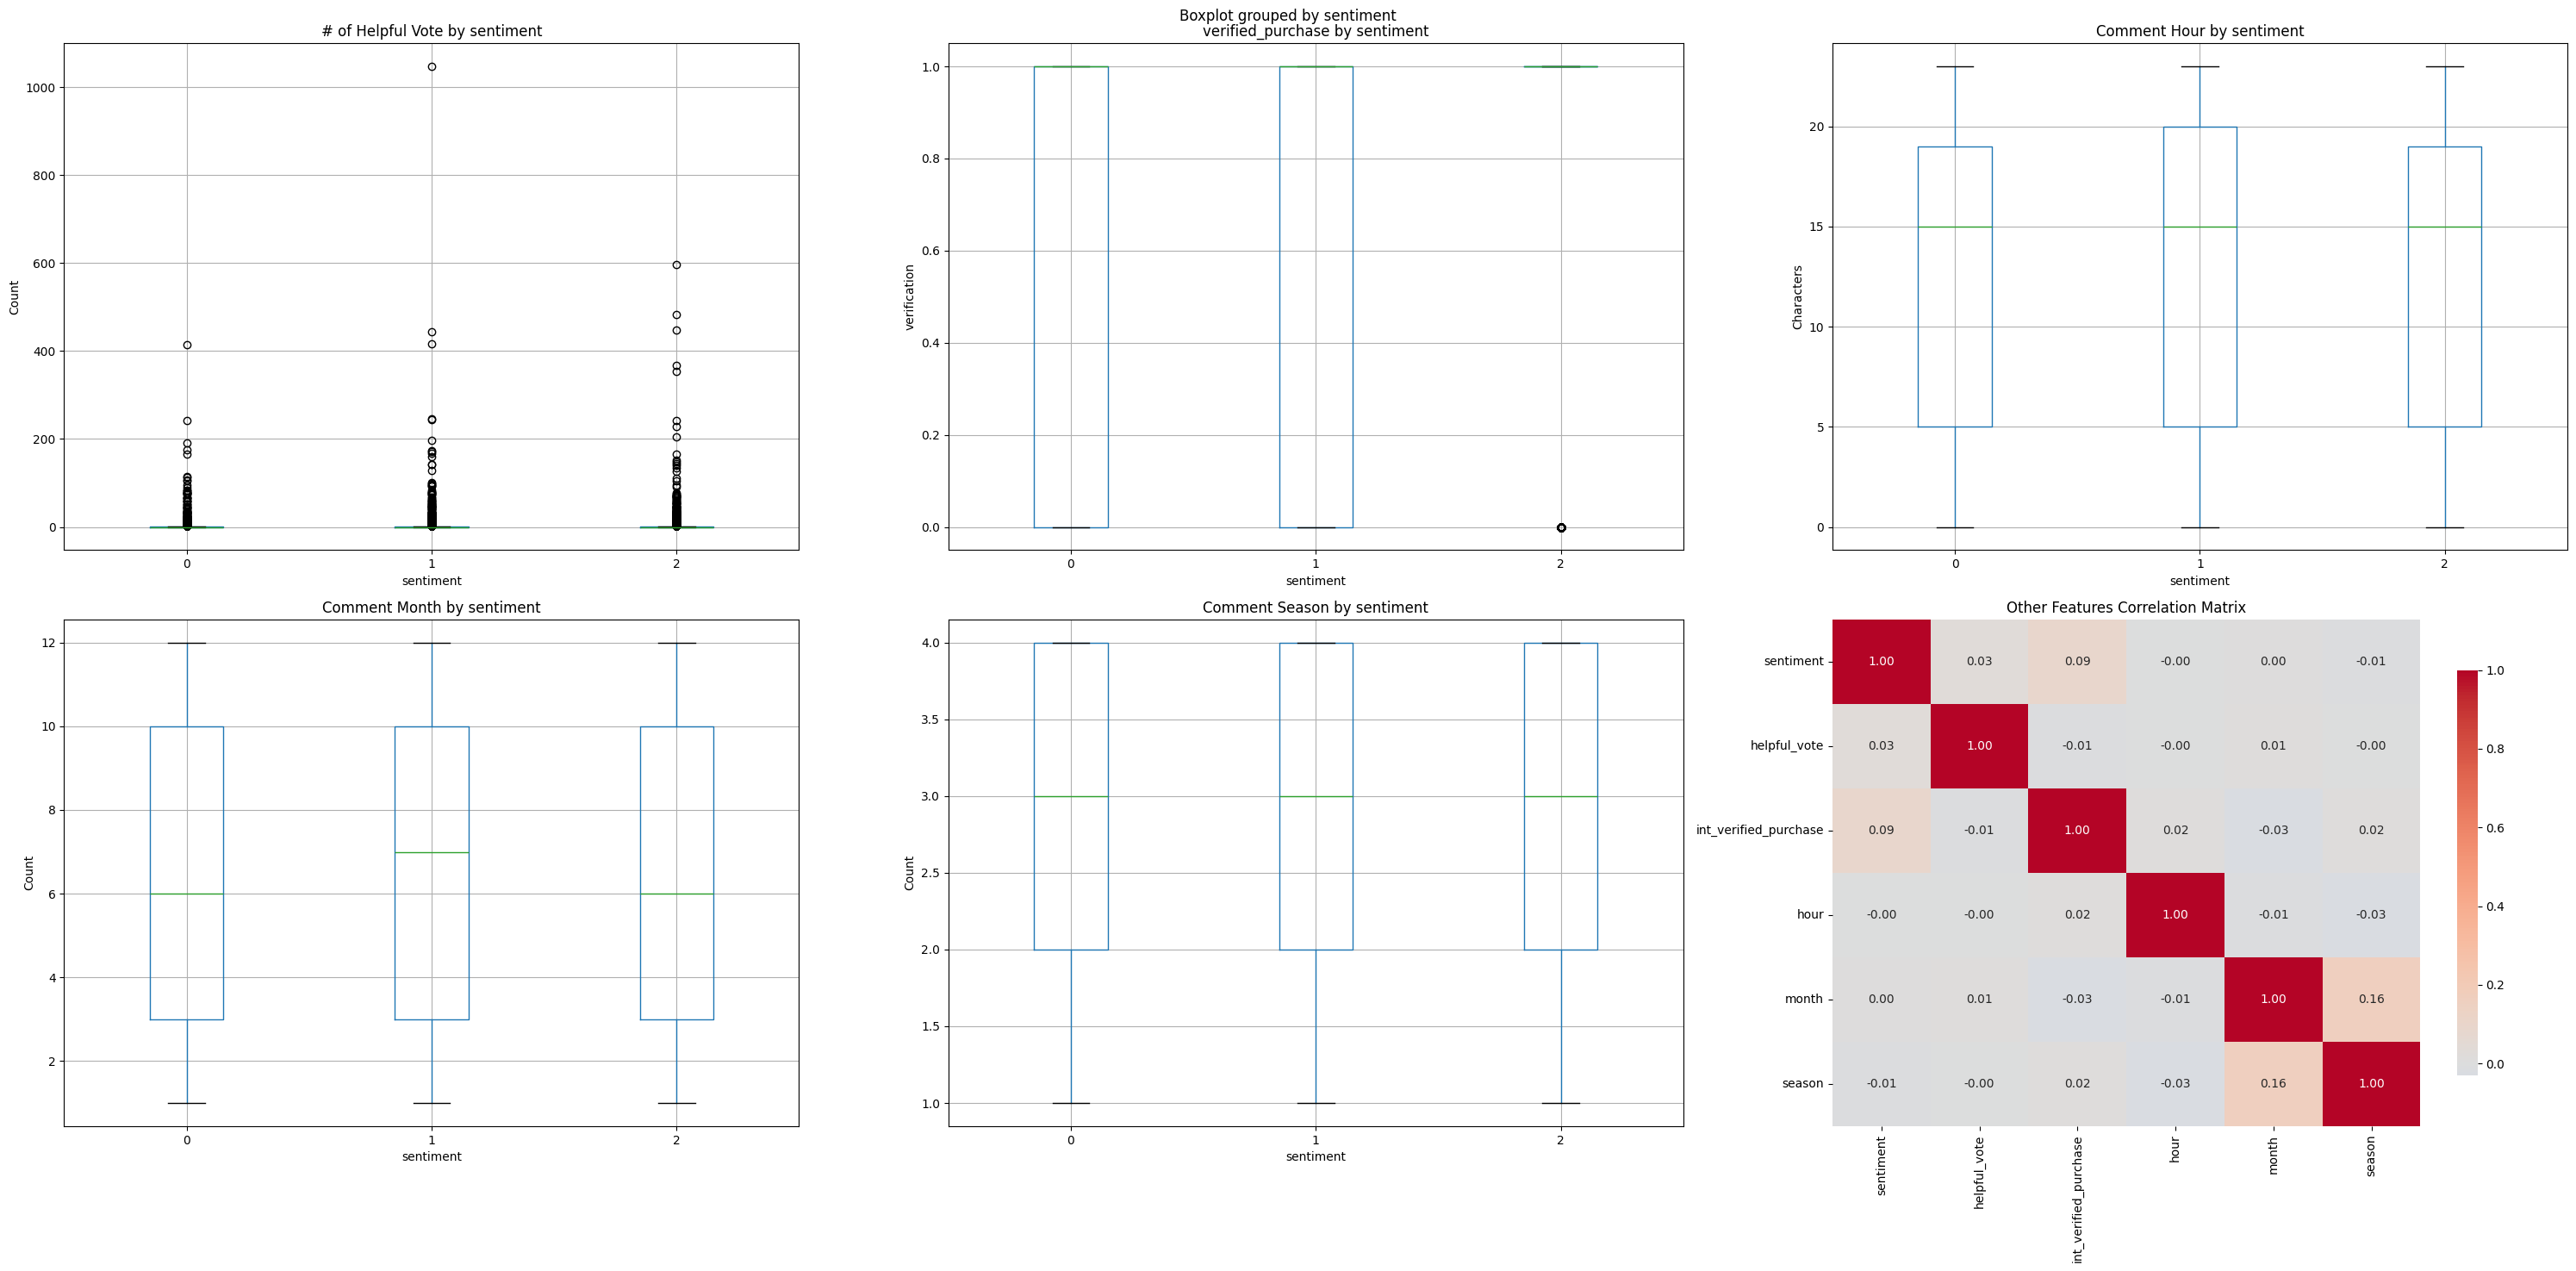

In [19]:
# PART 4: VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(30, 15))
fig.suptitle('Other features Analysis by sentiment', fontsize=16, fontweight='bold')

# 1. helpful_vote
df.boxplot(column='helpful_vote', by='sentiment', ax=axes[0, 0])
axes[0, 0].set_title('# of Helpful Vote by sentiment')
axes[0, 0].set_xlabel('sentiment')
axes[0, 0].set_ylabel('Count')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# 2. int_verified_purchase
df.boxplot(column='int_verified_purchase', by='sentiment', ax=axes[0, 1])
axes[0, 1].set_title('verified_purchase by sentiment')
axes[0, 1].set_xlabel('sentiment')
axes[0, 1].set_ylabel('verification')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# 3. Comment hour
df.boxplot(column='hour', by='sentiment', ax=axes[0, 2])
axes[0, 2].set_title('Comment Hour by sentiment')
axes[0, 2].set_xlabel('sentiment')
axes[0, 2].set_ylabel('Characters')
plt.sca(axes[0, 2])
plt.xticks(rotation=0)

# 4. Comment month
df.boxplot(column='month', by='sentiment', ax=axes[1, 0])
axes[1, 0].set_title('Comment Month by sentiment')
axes[1, 0].set_xlabel('sentiment')
axes[1, 0].set_ylabel('Count')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 5. Comment season
df.boxplot(column='season', by='sentiment', ax=axes[1, 1])
axes[1, 1].set_title('Comment Season by sentiment')
axes[1, 1].set_xlabel('sentiment')
axes[1, 1].set_ylabel('Count')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

# 9. Correlation heatmap
corr_features = ["sentiment","helpful_vote","int_verified_purchase","hour", "month", "season"]
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1, 2], cbar_kws={'shrink': 0.8})
axes[1, 2].set_title('Other Features Correlation Matrix')
plt.tight_layout()
# plt.savefig("other_features_analysis1.png")
plt.show()

In [20]:
# 5. Check for multicollinearity
print("\nother_features MULTICOLLINEARITY CHECK")
print("-" * 80)
high_corr_pairs = []
for i in range(len(other_features)):
    for j in range(i+1, len(other_features)):
        corr_val = df[other_features[i]].corr(df[other_features[j]])
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((other_features[i], other_features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.8)")



other_features MULTICOLLINEARITY CHECK
--------------------------------------------------------------------------------
No highly correlated features found (threshold: 0.8)


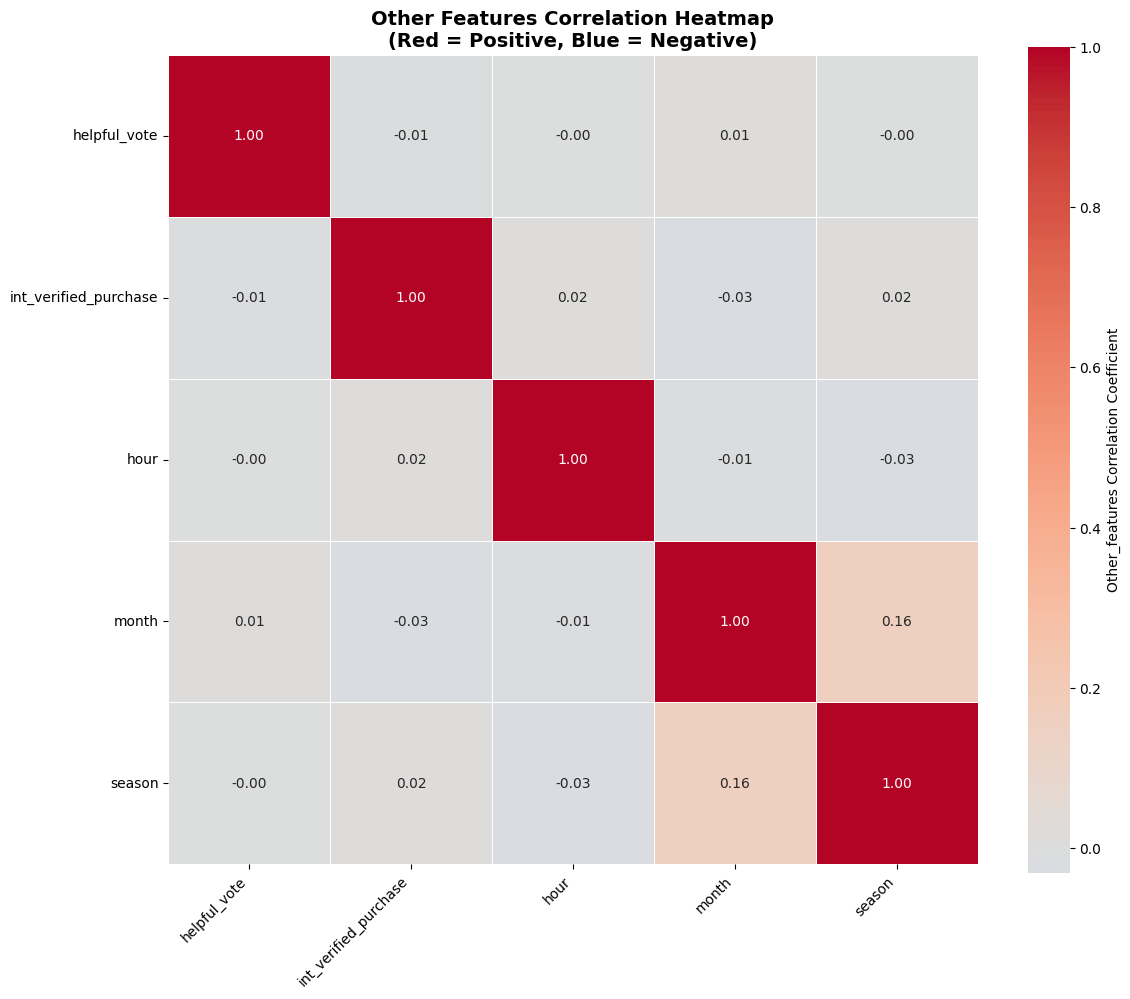

In [21]:
#6.  CORRELATION MATRIX BETWEEN OTHER_FEATURES

corr_matrix = df[other_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'Other_features Correlation Coefficient'})

plt.title('Other Features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the file
# plt.savefig("multicolinarity_heatmap_other_features.png", dpi=300, bbox_inches='tight')
plt.show()

# “features": "text_features" + "other_features"

In [22]:
# 1. CORRELATION WITH sentiment

print("ALl featrues: CORRELATION WITH sentiment")

# Calculate correlation of each feature with sentiment
correlations = df[features + ['sentiment']].corr()['sentiment'].sort_values(ascending=False)
print("\n", correlations)

ALl featrues: CORRELATION WITH sentiment

 sentiment                1.000000
int_verified_purchase    0.088731
question_count           0.064425
all_caps_words           0.044342
helpful_vote             0.031630
uppercase_ratio          0.023703
month                    0.001984
hour                    -0.002227
total_punctuation       -0.006350
season                  -0.008761
word_count              -0.010024
char_count              -0.010560
avg_word_length         -0.019400
exclamation_count       -0.040582
Name: sentiment, dtype: float64


In [23]:
# 2.1. Check for multicollinearity by threshold = 0.8
print("All MULTICOLLINEARITY CHECK, threshold = 0.8")
print("-" * 80)
high_corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_val = df[features[i]].corr(df[features[j]])
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((features[i], features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.8)")


All MULTICOLLINEARITY CHECK, threshold = 0.8
--------------------------------------------------------------------------------
Highly correlated feature pairs (>0.8):
  - word_count <-> char_count: 0.997
  - word_count <-> total_punctuation: 0.935
  - char_count <-> total_punctuation: 0.938

Recommendation: Keep only one feature from each highly correlated pair


In [24]:
# 2.2.  Check for multicollinearity - The Percentile Approach (Distribution-Based) - calculate new threshold

# Calculate the absolute correlation matrix
corr_matrix = df[features].corr().abs()

# Extract only the upper triangle (to avoid self-correlation and duplicates)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
all_corrs = upper_tri.stack().values

# Dynamically set threshold at the 95th percentile
dynamic_threshold = np.percentile(all_corrs, 95)
print(f"Suggested threshold based on data distribution: {dynamic_threshold:.3f}")


Suggested threshold based on data distribution: 0.398


In [25]:
# 2.2.  Check for multicollinearity - The Percentile Approach (Distribution-Based), threshold = 0.380
print("All MULTICOLLINEARITY CHECK, threshold = 0.380")
print("-" * 80)
high_corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_val = df[features[i]].corr(df[features[j]])
        if abs(corr_val) > 0.380:
            high_corr_pairs.append((features[i], features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.380):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.380)")


All MULTICOLLINEARITY CHECK, threshold = 0.380
--------------------------------------------------------------------------------
Highly correlated feature pairs (>0.380):
  - word_count <-> char_count: 0.997
  - word_count <-> all_caps_words: 0.397
  - word_count <-> total_punctuation: 0.935
  - word_count <-> int_verified_purchase: -0.389
  - char_count <-> all_caps_words: 0.405
  - char_count <-> total_punctuation: 0.938
  - char_count <-> int_verified_purchase: -0.387

Recommendation: Keep only one feature from each highly correlated pair


In [26]:
# 2.3.  Check for multicollinearity - VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, features):
    # Ensure data is numeric and handle missing values
    X = df[features].dropna()
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]
    
    return vif_data.sort_values(by="VIF", ascending=False)

# 1. Calculate all VIF scores
vif_results = calculate_vif(df, features)

# 2. Filter and print only features with VIF > 5
high_vif = vif_results[vif_results["VIF"] > 5]

if not high_vif.empty:
    print("\n[ALERT] Features with high multicollinearity (VIF > 5):")
    print("-" * 50)
    print(high_vif.to_string(index=False))
    print("-" * 50)
    print("Justification: These features are highly predictable by other variables,")
    print("which can destabilize model coefficients and hide true feature importance.")
else:
    print("\n[OK] No features found with VIF > 5.")


[ALERT] Features with high multicollinearity (VIF > 5):
--------------------------------------------------
          feature        VIF
       char_count 242.633181
       word_count 229.411866
total_punctuation  14.819791
  avg_word_length  13.302711
           season   5.997028
--------------------------------------------------
Justification: These features are highly predictable by other variables,
which can destabilize model coefficients and hide true feature importance.


                   char_count  word_count  total_punctuation  avg_word_length  \
char_count           1.000000    0.996785           0.937910         0.113173   
word_count           0.996785    1.000000           0.934647         0.083760   
total_punctuation    0.937910    0.934647           1.000000         0.130766   
avg_word_length      0.113173    0.083760           0.130766         1.000000   
season              -0.011415   -0.010724          -0.012246        -0.008014   

                     season  
char_count        -0.011415  
word_count        -0.010724  
total_punctuation -0.012246  
avg_word_length   -0.008014  
season             1.000000  


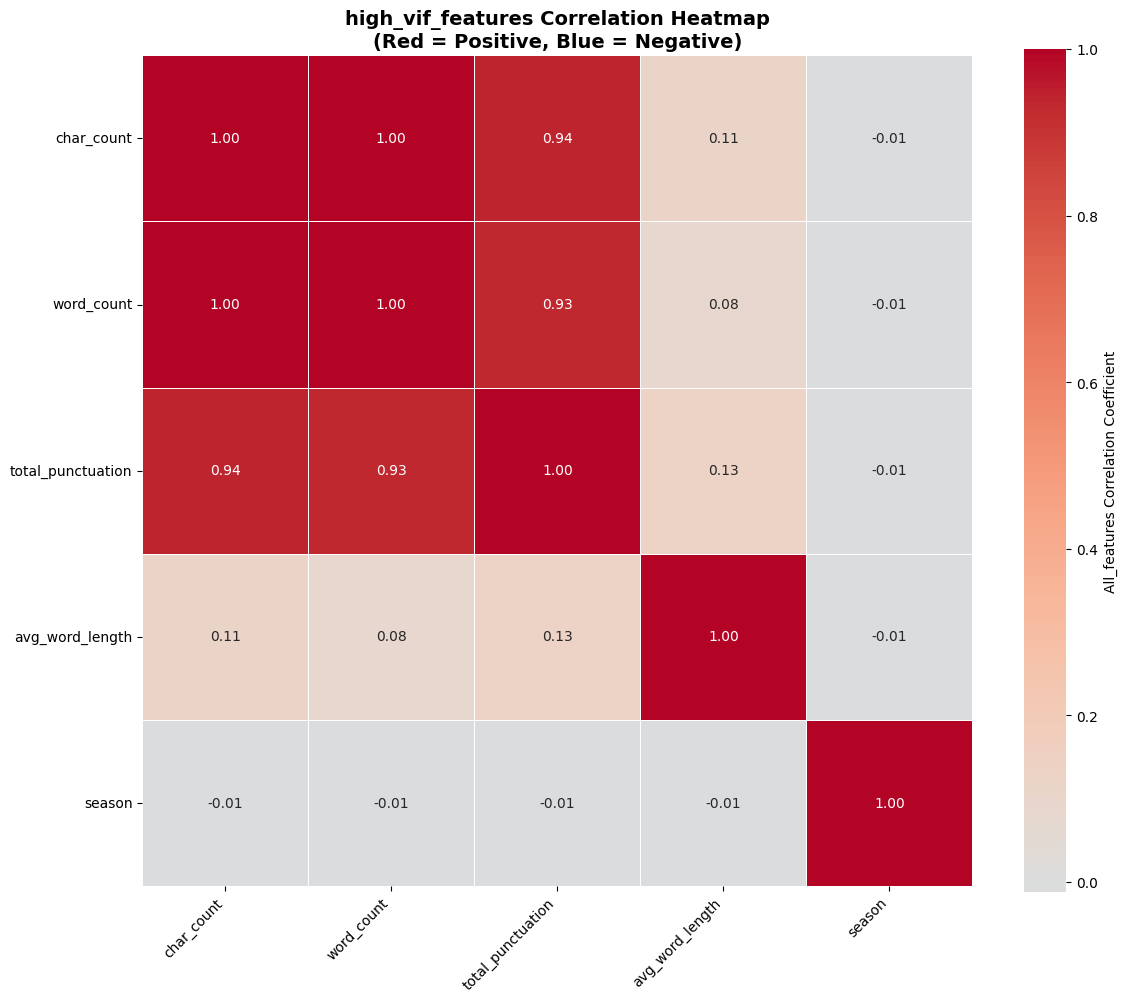

In [27]:
# 2.3.  Check for multicollinearity - VIF
high_vif_features = ['char_count', 'word_count', 'total_punctuation', 'avg_word_length', 'season']

corr_matrix = df[high_vif_features].corr()
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'All_features Correlation Coefficient'})

plt.title('high_vif_features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

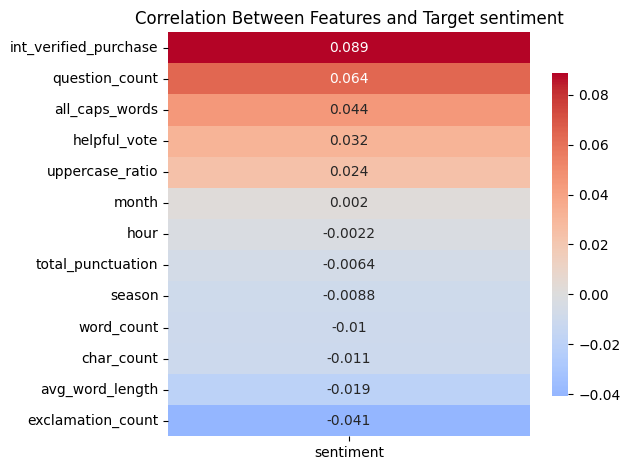

In [28]:
# 3. DESCENDING CORRELATION VISUALIZATION
corr_features_all = ["sentiment"] + features

corr_with_sentiment = df[corr_features_all].corr()[["sentiment"]].drop("sentiment").sort_values("sentiment", ascending=False)

sns.heatmap(
    corr_with_sentiment,
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Between Features and Target sentiment")
plt.tight_layout()
# plt.savefig("correlation between target and (all) features_1.png")
plt.show()


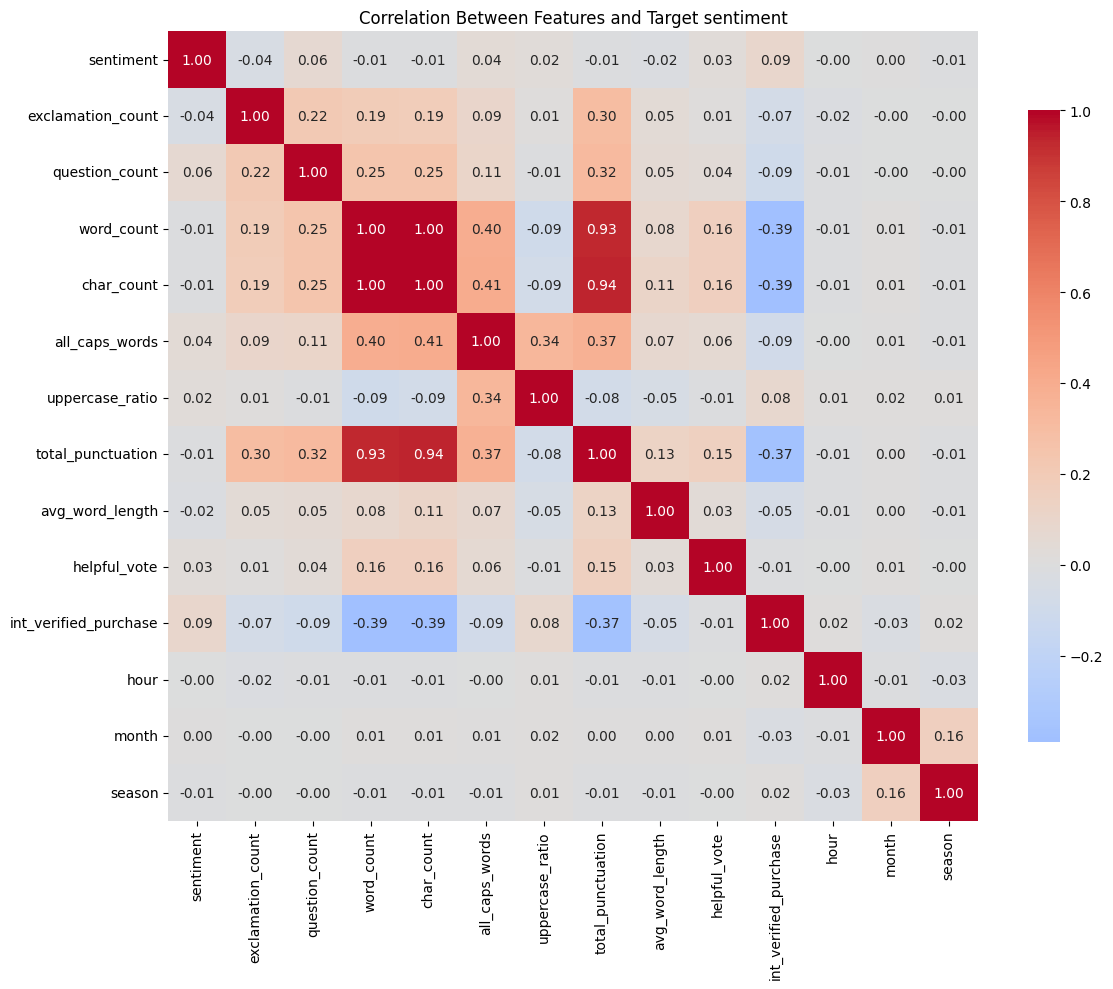

In [29]:
# 4. CORRELATION WITH TARGET FULL VISUALIZATION
corr_features_all = ["sentiment"] + features
plt.figure(figsize=(12, 10))
corr_with_sentiment = df[corr_features_all].corr()

sns.heatmap(
    corr_with_sentiment,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Between Features and Target sentiment")
plt.tight_layout()
# plt.savefig("correlation between target and (all) features_2.png")
plt.show()


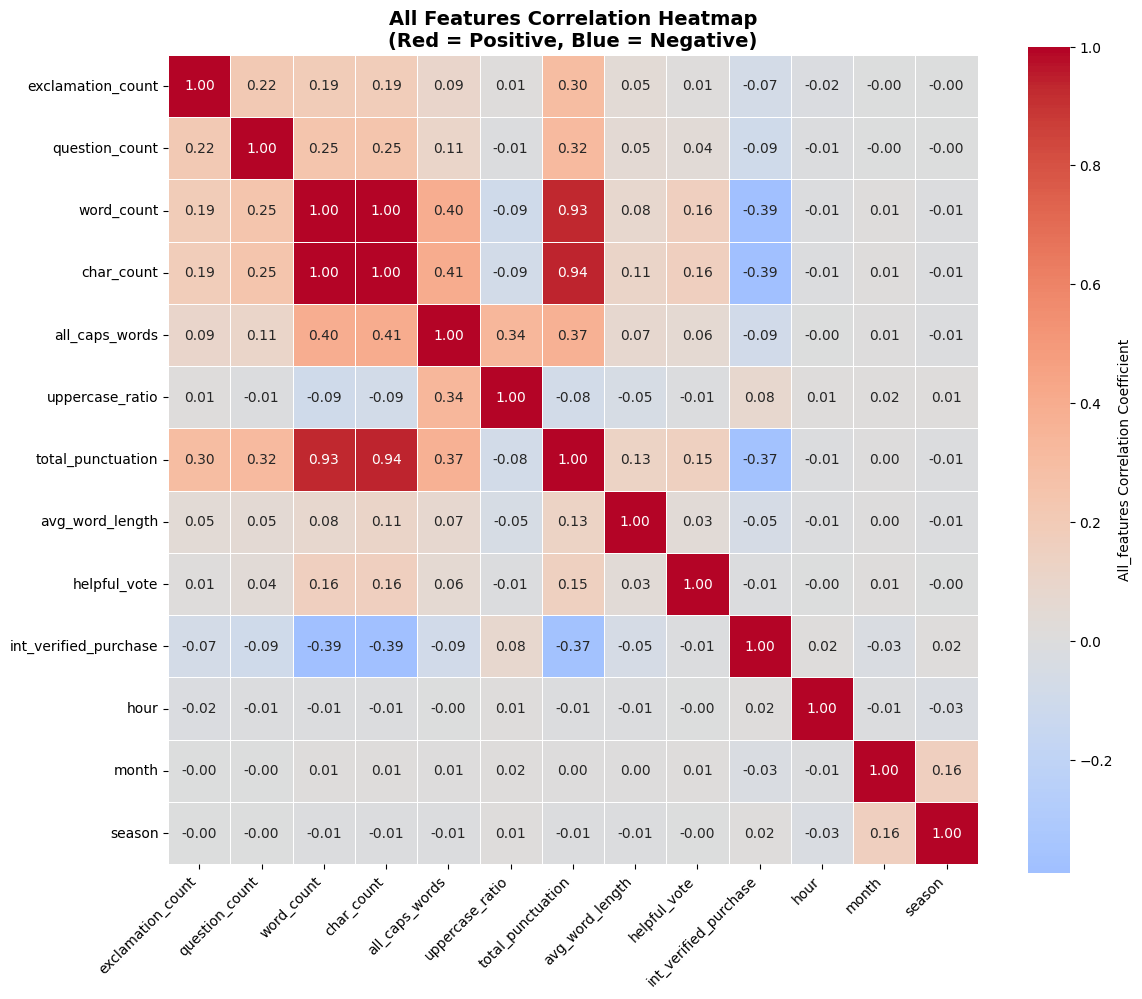

In [30]:
# 5. CORRELATION MATRIX BETWEEN ALL FEATURES
# Create correlation matrix
corr_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'All_features Correlation Coefficient'})

plt.title('All Features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the file
# plt.savefig("multicolinarity_heatmap_(all)features.png", dpi=300, bbox_inches='tight')
plt.show()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18400 entries, 0 to 18399
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   category               18400 non-null  object        
 1   rating                 18400 non-null  float64       
 2   sentiment              18400 non-null  int64         
 3   tokens                 18400 non-null  object        
 4   text_cleaned           18400 non-null  object        
 5   original_text          18400 non-null  object        
 6   token_count            18400 non-null  int64         
 7   title                  18400 non-null  object        
 8   images                 18400 non-null  object        
 9   verified_purchase      18400 non-null  bool          
 10  asin                   18400 non-null  object        
 11  parent_asin            18400 non-null  object        
 12  user_id                18400 non-null  object        
 13  d

In [32]:
# df.to_parquet('amazon_user_reviews_regular_ML.parquet', index=False)

In [33]:
simplified_col = ["sentiment"] + features
simplified_df = df[simplified_col]
simplified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18400 entries, 0 to 18399
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiment              18400 non-null  int64  
 1   exclamation_count      18400 non-null  int64  
 2   question_count         18400 non-null  int64  
 3   word_count             18400 non-null  int64  
 4   char_count             18400 non-null  int64  
 5   all_caps_words         18400 non-null  int64  
 6   uppercase_ratio        18400 non-null  float64
 7   total_punctuation      18400 non-null  int64  
 8   avg_word_length        18400 non-null  float64
 9   helpful_vote           18400 non-null  int64  
 10  int_verified_purchase  18400 non-null  int64  
 11  hour                   18400 non-null  int32  
 12  month                  18400 non-null  int32  
 13  season                 18400 non-null  int64  
dtypes: float64(2), int32(2), int64(10)
memory usage: 1.8 M

In [35]:
simplified_df.to_parquet('amazon_user_reviews_regular_ML_simplified.parquet', index=False)